# OpenCV Filters Webcam

In this notebook, several filters will be applied to webcam images.

Those input sources and applied filters will then be displayed either directly in the notebook or on HDMI output.

To run all cells in this notebook a webcam and HDMI output monitor are required.  

## 1. Start HDMI output 
### Step 1: Load the overlay

In [1]:
from pynq import Overlay
Overlay("base.bit").download()

### Step 2: Initialize HDMI I/O

In [2]:
from pynq.drivers.video import HDMI
hdmi_out = HDMI('out')
hdmi_out.start()

## 2. Applying OpenCV filters on Webcam input
### Step 1: Initialize Webcam and set HDMI Out resolution

In [9]:
# monitor configuration: 640*480 @ 60Hz
hdmi_out.mode(HDMI.VMODE_640x480)
hdmi_out.start()
# monitor (output) frame buffer size
frame_out_w = 1920
frame_out_h = 1080
# camera (input) configuration
frame_in_w = 640
frame_in_h = 480

### Step 2: Initialize camera from OpenCV

In [10]:
from pynq.drivers.video import Frame
import cv2

videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);
print("capture device is open: " + str(videoIn.isOpened()))

capture device is open: True


### Step 3: Send webcam input to HDMI output

In [11]:
import numpy as np

ret, frame_vga = videoIn.read()

if (ret):
    frame_1080p = np.zeros((1080,1920,3)).astype(np.uint8)
    frame_1080p[0:480,0:640,:] = frame_vga[0:480,0:640,:]
    hdmi_out.frame_raw(bytearray(frame_1080p.astype(np.int8)))
else:
    raise RuntimeError("Error while reading from camera.")

### Step 4: Edge detection 
Detecting edges on webcam input and display on HDMI out.

In [12]:
frame_1080p = np.zeros((1080,1920,3)).astype(np.uint8)

num_frames = 20
readError = 0

start = time.time()
for i in range (num_frames):   
    # read next image
    ret, frame_vga = videoIn.read()
    if (ret):
        laplacian_frame = cv2.Laplacian(frame_vga, cv2.CV_8U)
        # copy to frame buffer / show on monitor reorder RGB (HDMI = GBR)
        frame_1080p[0:480,0:640,[0,1,2]] = laplacian_frame[0:480,0:640,[1,0,2]]
        hdmi_out.frame_raw(bytearray(frame_1080p.astype(np.int8)))
    else:
        readError += 1
end = time.time()

print("Frames per second: " + str((num_frames-readError) / (end - start)))
print("Number of read errors: " + str(readError))

Frames per second:     3.118860504092142
Number of read errors: 0


### Step 5: Canny edge detection
Detecting edges on webcam input and display on HDMI out.

Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to “sure-edge” pixels, they are considered to be part of edges. Otherwise, they are also discarded. 

In [13]:
frame_1080p = np.zeros((1080,1920,3)).astype(np.uint8)

num_frames = 20

start = time.time()
for i in range (num_frames):
    # read next image
    ret, frame_webcam = videoIn.read()
    if (ret):
        frame_canny = cv2.Canny(frame_webcam,100,110)
        frame_1080p[0:480,0:640,0] = frame_canny[0:480,0:640]
        frame_1080p[0:480,0:640,1] = frame_canny[0:480,0:640]
        frame_1080p[0:480,0:640,2] = frame_canny[0:480,0:640]
        # copy to frame buffer / show on monitor
        hdmi_out.frame_raw(bytearray(frame_1080p.astype(np.int8)))
    else:
        readError += 1
end = time.time()

print("Frames per second: " + str((num_frames-readError) / (end - start)))
print("Number of read errors: " + str(readError))

Frames per second:     3.0896893281323927
Number of read errors: 0


### Step 6: Show results
Now use matplotlib to show filtered webcam input inside notebook

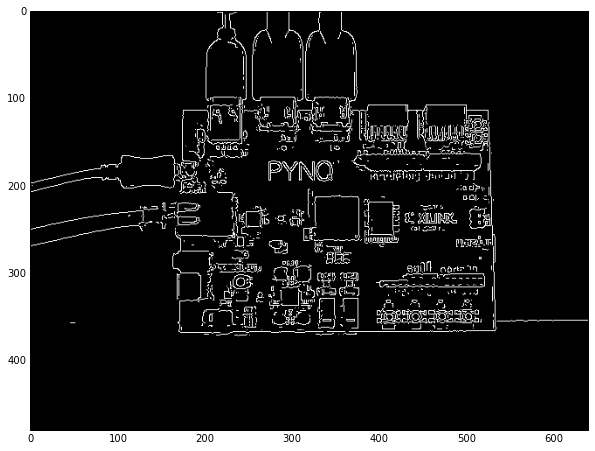

In [14]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np

plt.figure(1, figsize=(10, 10))
frame_vga = np.zeros((480,640,3)).astype(np.uint8)
frame_vga[0:480,0:640,0] = frame_canny[0:480,0:640]
frame_vga[0:480,0:640,1] = frame_canny[0:480,0:640]
frame_vga[0:480,0:640,2] = frame_canny[0:480,0:640]
plt.imshow(frame_vga[:,:,[2,1,0]])
plt.show()

### Step 7: Release camera and HDMI

In [15]:
videoIn.release()
hdmi_out.stop()]
del hdmi_out